![Logo](../assets/logo.png)

Made by **Domonkos Nagy**

[<img src="../assets/open_button.png">](https://colab.research.google.com/github/Fortuz/rl_education/blob/main/7.%20Planning%20and%20Learning/maze.ipynb)

# Maze

In this notebook we consider the problem of solving a maze in only a few episodes.

![Example](assets/maze.gif)

This maze environment was originally made with the `gym` library, but we apply an API compatibility layer, so it behaves exactly like
a `gymnasium` environment. The states are the x, y coordinates of the agent (which we transform to be respresented by a single integer), and the actions are the 4 directions: 'N', 'S', 'E' and 'W'. The reward
is -0.1/(number of cells) for each step, and for reaching the goal, a reward of +1 is received.

The maze is randomly generated every time the environment is created. To find the optimal path in only a small number of episodes, we are going to use
*Prioritized Sweeping*.

- Documentation for the Maze environment: https://github.com/MattChanTK/gym-maze

In [1]:
import gym
import gym_maze
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
from gymnasium.wrappers import TransformObservation
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
# initializing gym environment with gymnasium compatibility
env = gym.make("maze-random-10x10-v0", apply_api_compatibility=True)
# transforming observation representation from array to int: e.g. [3, 4] -> 43
env = TransformObservation(env, lambda obs: int(obs[1] * (env.observation_space.high + 1)[0] + obs[0]))

error: XDG_RUNTIME_DIR not set in the environment.


In [3]:
# initializing q-table
action_space_size = env.action_space.n
observation_space_size = (env.observation_space.high + 1)[0] * \
    (env.observation_space.high + 1)[1]
shape = observation_space_size, action_space_size

q_table = np.zeros(shape)

# initializing model
model_state = np.zeros(shape)
model_reward = np.zeros(shape)

# initializing priority queue
priorities = np.zeros(shape)

In [4]:
# argmax function that breaks ties randomly
def argmax(arr):
    arr_max = np.max(arr)
    return np.random.choice(np.where(arr == arr_max)[0])

## The Model

In addition to the Q-table, the agent also learns a model of the environment. Since the maze is deterministic, the model is pretty simple:
for each state-action pair, the model stores the next state and reward: $\text{Model}(S_t, A_t) = R_{t+1}, S_{t+1}$. The `add` method
is used to add new information to the model, while the `get` method returns the reward and next state for a given state-action pair.
The `get_leading` method returns all state-action pairs that lead to a given state.

In [5]:
# class representing our model of the environment
class Model:
    def __init__(self, shape):
        self.states = np.zeros(shape, dtype=int) - 1
        self.rewards = np.zeros(shape)
        self.states_reverse = {}

    # add new information to the model:
    # taking 'action' in 'state' produces 'reward'
    # and transfers the agent to 'new_state'
    def add(self, state, action, reward, new_state):
        self.states[state, action] = new_state
        self.rewards[state, action] = reward

        if new_state in self.states_reverse:
            if not (state, action) in self.states_reverse[new_state]:
                self.states_reverse[new_state].append((state, action))
        else:
            self.states_reverse[new_state] = [(state, action)]

    # get information from the model:
    def get(self, state, action):
        new_state = self.states[state, action]
        reward = self.rewards[state, action]
        return new_state, reward

    # get all state-action pairs that lead the agent to 'state'
    def get_leading(self, state):
        return self.states_reverse[state]

In [6]:
# initializing model
model = Model(shape)

## Prioritized Sweeping

Prioritized sweeping works similarly to Q-learning, but in addition to updates based on real experience (*learning*) it also utilizes updates based on simulated
experience (*planning*). To be able to do this, the algorithm records each state transition, forming a model of the environment.

A simpler, similar algorithm is called *Dyna-Q*: it is essentially Q-learning with state transitions being recorded to a model, and after each step, randomly selected
Q-values are being updated using information from the model.
Prioritized sweeping improves on Dyna-Q by focusing on updating state-action pairs with higher temporal-difference error values more frequently. By prioritizing updates based on the magnitude of the error, it accelerates the learning process by directing attention to the most critical areas of the environment, where value estimates need refinement, leading to quicker convergence.

Since state-action pairs that lead to a state with a high error are likely to have a high TD error themselves, after each update, the errors of state-action pairs that lead to the newly updated state are recalculated. This leads to a quick backpropagation of rewards: for example, in the maze environment, after the goal state is reached, prioritized sweeping will
first update the state-action pair leading to the goal state, then the state-action pairs leading to the state just before the goal state, and so on, spreading backwards from the
goal to the starting state.

In this example, the agent learns to solve the maze in only 3 episodes, with 200 planning updates after each step. In real-world applications, learning and planning are usually parallelized: the agent is always reactive and always deliberative, responding instantly to the latest sensory information and yet always planning in the
background.

In [7]:
# hyperparameters
N_EPISODES = 3
N_UPDATES_PER_STEP = 200  # planning updates per interaction with the environment

ALPHA = 0.7  # learning rate
GAMMA = 1  # discount rate
THETA = 0.01  # priority treshold
C = 5  # exploration rate (UCB)

In [8]:
def plan():
    for _ in range(N_UPDATES_PER_STEP):
        # get state-action pair with highest priority
        state, action = np.unravel_index(priorities.argmax(), priorities.shape)
        if priorities[state, action] == 0:
            break

        # reset priority
        priorities[state, action] = 0

        # get new state and reward from model
        new_state, reward = model.get(state, action)

        # update q-table
        q_table[state, action] = q_table[state, action] * (1 - ALPHA) + \
            ALPHA * (reward + GAMMA * np.max(q_table[new_state, :]))

        # add leading states to queue
        for prev_state, prev_action in model.get_leading(state):
            _, prev_reward = model.get(prev_state, prev_action)
            priority = abs(prev_reward + GAMMA *
                           np.max(q_table[state, :] - q_table[prev_state, prev_action]))

            if priorities[prev_state, prev_action] < priority and priority > THETA:
                priorities[prev_state, prev_action] = priority

In [9]:
for episode in range(N_EPISODES):
    state, _ = env.reset()
    done = False
    n = 0
    selections = np.zeros(shape)

    while not done:
        n += 1

        # UCB action selection
        UCB_estimations = q_table[state, :] + C * np.sqrt(np.log(n) / (selections[state, :] + 1e-5))
        action = argmax(UCB_estimations)

        selections[state, action] += 1

        # take the selected action
        new_state, reward, done, truncated, info = env.step(['N', 'S', 'E', 'W'][action])
        # add information to the model
        model.add(state, action, reward, new_state)

        # add state-action pair to queue
        priority = abs(reward + GAMMA *
                       np.max(q_table[new_state, :] - q_table[state, action]))

        if priorities[state, action] < priority and priority > THETA:
            priorities[state, action] = priority

        state = new_state
        plan()

    print(f'Episode {episode}:\n\tSteps: {n}\n\tQueue size: {np.count_nonzero(priorities)}')
    
# Save the q-table
with open('q_table.bin', 'wb') as f:
    pickle.dump(q_table, f)

Episode 0:
	Steps: 3205
	Queue size: 65
Episode 1:
	Steps: 39
	Queue size: 100
Episode 2:
	Steps: 36
	Queue size: 45


**Playing the game**: Here we simulate an episode using the resulting policy:

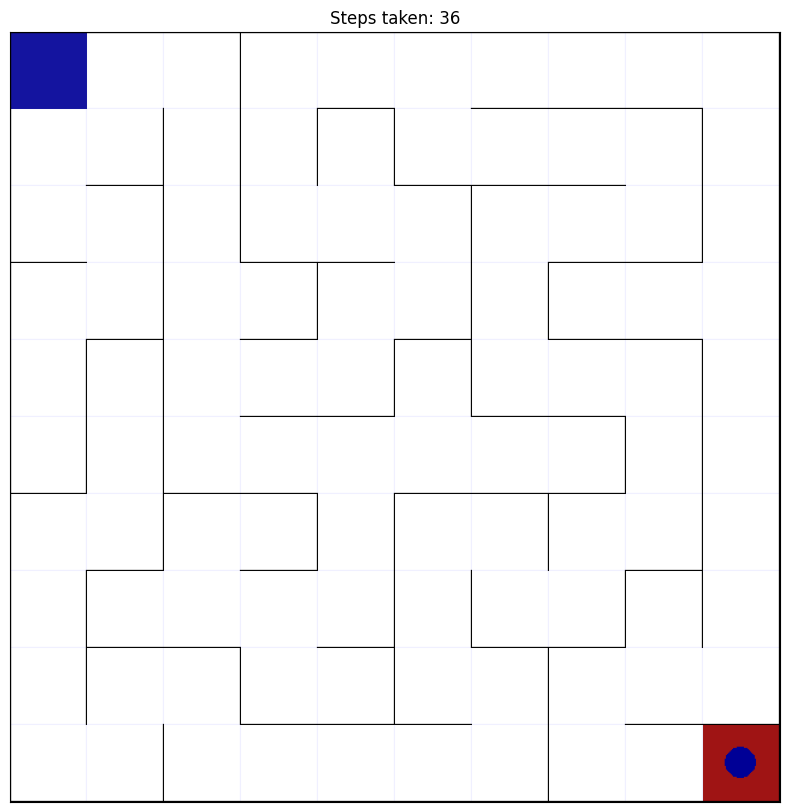

In [10]:
# initializing gym environment with gymnasium compatibility
env = gym.make("maze-random-10x10-v0", apply_api_compatibility=True)
# transforming observation representation from array to int: e.g. [3, 4] -> 43
env = TransformObservation(env, lambda obs: int(obs[1] * (env.observation_space.high + 1)[0] + obs[0]))

# Load the q-table
with open('q_table.bin', 'rb') as f:
    q_table = pickle.load(f)
    
# create figure
plt.figure(figsize=(10, 10))
plt.tick_params(left=False, right=False, labelleft=False,
                labelbottom=False, bottom=False)

# render starting state
state, _ = env.reset()
img = plt.imshow(env.render())

done = False
n_steps = 0

# play episode
while not done:
    # greedy action selection
    action = argmax(q_table[state, :])

    # take the selected action
    new_state, reward, done, truncated, info = env.step(['N', 'S', 'E', 'W'][action])
    n_steps += 1

    # render state
    img.set_data(env.render())
    plt.title(f'Steps taken: {n_steps}')
    display.display(plt.gcf())
    display.clear_output(wait=True)

    state = new_state